# Fair multi-class classification : $\epsilon$-fair

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Fair classification without $\epsilon$-fairness (see experimentation: exact fairness)

See Paper "multi-class classification" for notation.

- theoretical fair solution:

\begin{equation*}
\lambda^* \in \arg\min_{\lambda \in \mathbb{R}^K} \sum_{s \in \mathcal{S}} \mathbb{E}_{X|S=s}\left[\max_k\left(\pi_s p_k(X,s)-s\lambda_k\right)\right]\enspace .
\end{equation*}

\begin{equation*}
g_{{\rm fair}} ^{*}(x,s) \in \arg\max_{k} \left(\pi_s p_k(x,s)-s\lambda^*_k\right), \quad (x,s)\in\mathcal{X}\times\mathcal{S}\;.
\end{equation*} 

- emperical fair solution:

\begin{equation}
\label{eq:LamPlugIn}
\hat{\lambda} \in \arg\min_{\lambda} \sum_{s \in \mathcal{S}}
\frac{1}{N_s} \sum_{i=1}^{N_s} \left[\max_{k\in [K]} \left(\hat{\pi}_s \bar{p}_k(X_i^{s},s,\zeta^s_{k,i}) -s\lambda_k\right)\right].
\end{equation}

\begin{equation}
\label{eq:eqPlugIn}
\hat{g}(x,s) = \arg\max_{k\in [K]} \left(\hat{\pi}_s \bar{p}_k (x,s,\zeta_k)- s \hat{\lambda}_k\right)\, ,
\end{equation} 

## Fair classification with $\epsilon$-fairness

See Latex for notation.

- theoretical fair solution:

\begin{multline*}
(\lambda^*, \beta^*) \in
\arg\min_{(\lambda,\beta) \in \mathbb{R}_{+}^{2K}} \sum_{s \in \mathcal{S}} \mathbb{E}_{X|S=s}\left[\max_k\left(\pi_s p_k(X,s)-s(\lambda_k-\beta_k)\right)\right] + \varepsilon \sum_{k=1}^K (\lambda_k+\beta_k).
\end{multline*}
<font color="red">
\begin{equation*}
g_{{\rm fair}} ^{*}(x,s) \in \arg\max_{k} \left(\pi_s p_k(x,s)-s(\lambda^*_k-\beta^*_k)\right), \quad (x,s)\in\mathcal{X}\times\mathcal{S}\;.
\end{equation*}
</font>
We deduce that
\begin{equation*}
\lambda_k^*\beta_k^* = 0 \;\; {\rm and} \;\; \lambda_k^*+\beta_k^* \geq 0.
\end{equation*}
Hence, if $\lambda_k^*+\beta_k^* > 0$,
\begin{equation*}
\left|\mathbb{P}_{X|S=1}\left(g^{*}_{\lambda^*,\beta^*}(X,S) \neq k \right) - \mathbb{P}_{X|S=-1}\left(g^*_{\lambda^*, \beta^*}(X,S) \neq k \right) \right| = \varepsilon. 
\end{equation*}
In the case where $\lambda_k^* = \beta_k^* = 0$, we have
\begin{equation*}
\left|\mathbb{P}_{X|S=1}\left(g^{*}_{\lambda^*, \beta^*}(X,S) \neq k \right) - \mathbb{P}_{X|S=-1}\left(g^*_{\lambda^*, \beta^*}(X,S) \neq k \right) \right| \leq  \varepsilon
\end{equation*}

- emperical fair solution:

\begin{multline*}
(\hat\lambda, \hat\beta) \in
\arg\min_{(\lambda,\beta) \in \mathbb{R}_{+}^{2K}} \sum_{s \in \mathcal{S}} \frac{1}{N_s} \sum_{i=1}^{N_s} \left[\max_{k\in [K]}\left(\hat{\pi}_s \bar{p}_k(X_i^{s},s,\zeta^s_{k,i})-s(\lambda_k-\beta_k)\right)\right] + \varepsilon \sum_{k=1}^K (\lambda_k+\beta_k).
\end{multline*}
We deduce that
\begin{equation*}
\hat\lambda_k\hat\beta_k = 0 \;\; {\rm and} \;\; \hat\lambda_k+\hat\beta_k \geq 0.
\end{equation*}

## 1. Numerical experimentations: preliminaries

**Constants / global variables:**

In [2]:
# 6, 20, 3
# 4, 20, 3
K = 6
N_FEATURES = 20
N_CLUSTERS = 10
P = 0.75

**Usual libraries:**

In [3]:
## logistic regression for multi-class classification using a one-vs-rest
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import softmax
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import pandas as pd

**Random seed :**

In [4]:
np.random.seed(777)

**Fairness functions :**

In [5]:
# Functions for creating datasets and ploting the ML performances
from synthetic_data import make_unfair_classif, data_viz, make_unfair_poolclassif, data_viz_tsne

# Check the model's performance
from multiclass_performance import plot_confusion_matrix, get_multiclass_performance

# Optimization algorithm
from utils_optimization import optCE, optSAGD, optSCIPY, optSCIPY_bivar

# Functions for experimentation purposes
from multiclass_fairness import fair_soft_max, fair_hard_max, fair_each_score, prepare_fairness
from multiclass_fairness import run_fairness_experimentation, run_fair_each_score_experimentation, run_twomethods_experimentation
from multiclass_fairness import viz_fairness_results, print_fairness_results
from multiclass_fairness import analysis_argmax_fairness, analysis_params_fairness
from multiclass_fairness import viz_fairness_analysis, viz_fairness_distributions, viz_fairness_distributions_uncond, viz_fairness_distributions_


In [6]:
def viz_fairness_distributions_compact(yb, ybfs, ind0, ind1, accs, kss, add_title="eps-fair"):
    fig = plt.figure(figsize=(16, 2))
    ax = fig.add_axes([0,0,1,1])
    cl = 1

    sns.set_palette("colorblind", 10)
    sns.color_palette("colorblind", 10)

    plt.subplot(1, 3, 1)
    sns.kdeplot(yb[ind0, cl], shade= True, linewidth= 3)
    sns.kdeplot(yb[ind1, cl], shade= True, linewidth= 3, alpha = 0.45)
    plt.legend(labels=['S = -1',  'S = +1'])
    plt.title(f"unfair : class {cl}")

    plt.subplot(1, 3, 2)
    ybf = ybfs
    sns.kdeplot(ybf[ind0, cl], shade= True, linewidth= 3)
    sns.kdeplot(ybf[ind1, cl], shade= True, linewidth= 3, alpha = 0.45)
    plt.legend(labels=['S = -1', 'S = +1'])
    plt.title(f"{add_title} : class {cl}")
    
    plt.subplot(1, 3, 3)
    name = "fair_soft"
    x = np.arange(1, len(np.unique(ydfs))+1)
    plt.bar(x - 0.1, np.unique(ydfs[ind0], return_counts=True)[1]/len(ydfs[ind0]), alpha = 0.8, color = "steelblue", width=0.2)
    plt.bar(x + 0.1, np.unique(ydfs[ind1], return_counts=True)[1]/len(ydfs[ind1]), alpha = 0.8, color = "red", width=0.2)
    plt.ylabel('Density')
    plt.title(rf'{add_title} : Acc {round(np.mean(accs[name]), 2)} +/- {round(np.std(accs[name]), 2)}, $\hat U$ {round(np.mean(kss[name]), 2)} +/- {round(np.std(kss[name]), 2)}')
    plt.xticks(x)
    plt.legend(labels=['S = -1', 'S = +1'])
    plt.show()
    
def add_arrow(line, position=None, direction='right', size=30, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    try:
        if position is None:
            position = ydata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(ydata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1

        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color, lw = 2),
            size=size
        )
    except:
        if position is None:
            position = xdata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1

        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color, lw = 2),
            size=size
        )

def viz_eps_analysis(epsilon_interval, kss_by_epsilon, accs_by_epsilon, K, p, diagram=True):
    nc = 2 + diagram
    fig, axes = plt.subplots(nrows=1, ncols=nc, figsize=(16, 4))
    sns.set_palette("colorblind")

    param = "$\epsilon$"
    param_range = epsilon_interval

    for fair in ["fair_soft", "unfair"]:
        x = np.array(param_range)
        y = np.array([np.mean(kss_by_epsilon[i][fair]) for i in range(len(kss_by_epsilon))])
        std = np.array([np.std(kss_by_epsilon[i][fair]) for i in range(len(kss_by_epsilon))])
        fair_name = fair
        if fair == "fair_soft":
            fair_name = "eps-fair"
        axes[0].errorbar(x, y, label=fair_name, yerr=std)
        axes[0].fill_between(x, (y-std), (y+std), alpha=.3)
    axes[0].legend()
    axes[0].set_title(f"Unfairness evaluation w.r.t {param}", fontsize=16)
    axes[0].set_xlabel(param, fontsize=16)
    axes[0].set_ylabel("Unfairness", fontsize=16)

    for fair in ["fair_soft", "unfair"]:
        x = np.array(param_range)
        y = np.array([np.mean(accs_by_epsilon[i][fair]) for i in range(len(accs_by_epsilon))])
        std = np.array([np.std(accs_by_epsilon[i][fair]) for i in range(len(accs_by_epsilon))])
        fair_name = fair
        if fair == "fair_soft":
            fair_name = "eps-fair"
        axes[1].errorbar(x, y, label=fair_name, yerr=std)
        axes[1].fill_between(x, (y-std), (y+std), alpha=.3)
    axes[1].legend()
    axes[1].set_title(f"Model evaluation w.r.t {param}", fontsize=16)
    axes[1].set_xlabel(param, fontsize=16)
    axes[1].set_ylabel("Accuracy", fontsize=16)
    
    if diagram:
        fair_name = "eps-fair"
        fair = "fair_soft"
        x = np.array([np.mean(kss_by_epsilon[i][fair]) for i in range(len(kss_by_epsilon))])
        y = np.array([np.mean(accs_by_epsilon[i][fair]) for i in range(len(accs_by_epsilon))])
        line = axes[2].plot(x, y, label=fair_name, lw = 2, marker = "o")[0]
        add_arrow(line)
        line.axes.annotate(f"{param} = {param_range[-1]}",
            xytext=(x[-1]-0.02, y[-1]+0.02),
            xy=(x[-1], y[-1]),
            size=12
        )
        color = line.get_color()
        axes[2].scatter(x[0], y[0], marker = "o", color=color)
        axes[2].scatter(x[-1], y[-1], marker = "o", color=color)
        for r in np.arange(0.05, 2, 0.05):
            axes[2].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.3))
        line.axes.annotate(f"{param} = {param_range[0]}",
                xytext=(x[0]-0.02, y[0]-0.04),
                xy=(x[0], y[0]),
                size=12
            )
        axes[2].scatter(x[0], y[0], marker = "o", color=color)
        x_u = np.mean([np.mean(kss_by_epsilon[i]["unfair"]) for i in range(len(kss_by_epsilon))])
        y_u = np.mean([np.mean(accs_by_epsilon[i]["unfair"]) for i in range(len(accs_by_epsilon))])
        axes[2].scatter(x_u, y_u, marker = "o", color="orange", label="unfair", s=200)
        axes[2].legend(loc="best")
        axes[2].set_title(f"Phase diagram, K = {K}, p = {p}", fontsize=16)
        axes[2].set_xlabel(r"Unfairness $\hat{\mathcal{U}}$", fontsize=16)
        axes[2].set_ylabel("Accuracy", fontsize=16)
        axes[2].set_xlim([0,x_u+0.01])
        axes[2].set_ylim([0.65,1])
    fig.tight_layout(pad=2.2)
    plt.show()

**Real datasets**

In [103]:
def get_data_crime(n_pool, K):
    # CRIME Dataset
    import scipy.io
    mat = scipy.io.loadmat('Crime.mat')
    x_crime = mat["X"]
    y_crime = mat["Y"]
    s_crime = mat["Scat"].astype(int)
    s_crime[s_crime == 0] = -1
    x_crime = np.concatenate((x_crime, s_crime), axis=1)
    print("shape of X :", x_crime.shape)
    
    # discretization of y
    cuts = np.quantile(y_crime, q = np.linspace(0, 1, num=K+1))
    y_categ = np.zeros(len(y_crime))
    
    for cl in range(K):
        index = (y_crime.flatten() >= cuts[cl]) & (y_crime.flatten() <= cuts[cl+1])
        y_categ[index] = cl
    print("stats of y (value, counts) :", np.unique(y_categ, return_counts=True))
    
    # split train-test-pool
    X_pool_crime = x_crime[:n_pool]
    X_train_crime, X_test_crime, y_train_crime, y_test_crime = train_test_split(x_crime[n_pool:], y_categ[n_pool:], test_size=0.3)
    
    # X_test_crime
    #X_test_crime = X_test_crime[:,:-1]
    #X_pool_crime = X_pool_crime
    
    y_train_crime, y_test_crime = np.array(y_train_crime, dtype=int), np.array(y_test_crime, dtype=int)
    
    print("shape of train :", X_train_crime.shape , y_train_crime.shape )
    print("shape of test :", X_test_crime.shape   , y_test_crime.shape  )
    print("shape of pool :", X_pool_crime.shape)
    
    X = np.array(x_crime[n_pool:])
    y = np.array(y_categ[n_pool:], dtype=int)
    X_pool = np.array(x_crime[:n_pool])
    X_train_full = np.array(x_crime)
    y_train_full = np.array(y_categ, dtype=int)
    return X, y, X_pool, X_train_full, y_train_full, X_train_crime, X_test_crime, y_train_crime, y_test_crime

def get_data_law(n_pool, K):
    sensitive_name = "race1"
    data = pd.read_csv("bar_pass_prediction.csv")
    #print(data.info())
    del data["ID"]
    column_names = [
        "sex",
        "decile1b",
        "decile3",
        'lsat',
        "tier",
        'pass_bar',
        'gpa',
        "age",
        "parttime",
        "fulltime",
        "fam_inc",
        'race1'
    ]

    data_law = data[column_names]

    print("Shape of X", data_law.shape)

    data_law.fillna(value=0, inplace=True)

    y_law = np.array(data_law["gpa"])
    del data_law["gpa"]

    x_law = data_law.copy()

    x_law.loc[x_law[sensitive_name] != "white", sensitive_name] = -1
    x_law.loc[x_law[sensitive_name] == "white", sensitive_name] = 1

    x_law[sensitive_name] = x_law[sensitive_name].astype(int)

    # preprocessing
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_law)
    x_law = scaler.transform(x_law)

    x_law[x_law[:,-1] == 0, -1] = -1
    x_law[x_law[:,-1] == 1, -1] = 1

    # discretization of y
    cuts = np.quantile(y_law, q = np.linspace(0, 1, num=K+1))
    y_categ = np.zeros(len(y_law))

    for cl in range(K):
        index = (y_law.flatten() >= cuts[cl]) & (y_law.flatten() <= cuts[cl+1])
        y_categ[index] = cl
    print("stats of y (value, counts) :", np.unique(y_categ, return_counts=True))

    # shuffle
    shuffle_indexes = np.arange(len(y_categ))
    np.random.shuffle(shuffle_indexes)
    x_law = np.array(x_law)[shuffle_indexes]
    y_categ = y_categ[shuffle_indexes]

    # split train-test-pool
    X_pool_law = x_law[:n_pool]
    x_law = x_law[n_pool:]
    y_categ = y_categ[n_pool:]
    X_train_law, X_test_law, y_train_law, y_test_law = train_test_split(x_law, y_categ, test_size=0.3)

    print("stats of sensitive feature (value, counts) :", np.unique(x_law[:,-1], return_counts=True))
    print("stats of y_train (value, counts) :", np.unique(y_train_law, return_counts=True))
    print("stats of y_test (value, counts) :", np.unique(y_test_law, return_counts=True))
    print("shape of train :", X_train_law.shape)
    print("shape of test :", X_test_law.shape)
    print("shape of pool :", X_pool_law.shape)

    # PARAMETERS
    X = np.array(x_law[n_pool:])
    y = np.array(y_categ[n_pool:], dtype=int)
    X_pool = x_law[:n_pool]
    X_train_full = np.array(x_law)
    y_train_full = np.array(y_categ, dtype=int)
    return X, y, X_pool, X_train_full, y_train_full

def get_data_cmc(n_pool, **args):
    # S = religion
    columns = ["age", "wife_education", "husband_education", "nb_children", "S", "working", "husband_occupation", "living", "media_exposure", "y"]
    url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data"
    data = pd.read_csv(url_data, header = None, names=columns, index_col=None)

    columns = ["age", "wife_education", "husband_education", "nb_children", "working", "husband_occupation", "living", "media_exposure", "y", "S"]
    data = data[columns]
    data.head()

    data.loc[data["S"] == 0, "S"] = -1

    y_cmc = data["y"]

    x_cmc = data
    del x_cmc["y"]

    print("shape of X :", x_cmc.shape)
    print("stats of y (value, counts) :", np.unique(y_cmc, return_counts=True))

    # preprocessing
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_cmc)
    x_cmc = scaler.transform(x_cmc)

    # shuffle
    shuffle_indexes = np.arange(len(y_cmc))
    np.random.shuffle(shuffle_indexes)
    x_cmc = np.array(x_cmc)[shuffle_indexes]
    y_cmc = np.array(y_cmc)[shuffle_indexes] - 1

    x_cmc[x_cmc[:,-1] == 0, -1] = -1
    x_cmc[x_cmc[:,-1] == 1, -1] = 1

    # split train-test-pool
    X_pool_cmc = x_cmc[:n_pool]
    X_train_cmc, X_test_cmc, y_train_cmc, y_test_cmc = train_test_split(x_cmc[n_pool:], y_cmc[n_pool:], test_size=0.35)

    print("stats of sensitive feature (value, counts) :", np.unique(x_cmc[:,-1], return_counts=True))
    print("stats of y_train (value, counts) :", np.unique(y_train_cmc, return_counts=True))
    print("stats of y_test (value, counts) :", np.unique(y_test_cmc, return_counts=True))
    print("shape of train :", X_train_cmc.shape)
    print("shape of test :", X_test_cmc.shape)
    print("shape of pool :", X_pool_cmc.shape)

    # PARAMETERS
    X = np.array(x_cmc[n_pool:])
    y = np.array(y_cmc[n_pool:], dtype=int)
    X_pool = x_cmc[:n_pool]
    X_train_full = np.array(x_cmc)
    y_train_full = np.array(y_cmc, dtype=int)
    return X, y, X_pool, X_train_full, y_train_full

def get_data_wine(n_pool, K):
    # Load dataset

    # S = color
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data_red = pd.read_csv(url, sep=";")

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    data_white = pd.read_csv(url, sep=";")


    data = pd.concat((data_red, data_white), axis = 0)
    print("data", data.shape)
    print("data_red", data_red.shape)
    print("data_white", data_white.shape)
    data.head()

    data["S"] = 1
    n = len(data_white)
    data.iloc[n:,-1] = -1

    print("stats of y_init (value, counts) :", np.unique(data["quality"], return_counts=True))
    
    if K!=2:
        yp = []
        for i in data["quality"]: # 3, 4, 5, 6, 7, 8, 9
            if(i==3 or i==4):
                yp.append([1,0,0,0,0])
            elif(i==5):
                yp.append([0,1,0,0,0])
            elif(i==6):
                yp.append([0,0,1,0,0])
            elif(i==7):
                yp.append([0,0,0,1,0])
            elif(i==8 or i==9):
                yp.append([0,0,0,0,1])
    else:
        yp = []
        for i in data["quality"]: # 3, 4, 5, 6, 7, 8, 9
            if(i==3 or i==4 or i==5):
                yp.append([1,0])
            else:
                yp.append([0,1])

    y_wine = np.argmax(np.array(yp), axis=1)
    x_wine = data
    del x_wine["quality"]
    #del x_wine["volatile acidity"] # TODO:TEST
    #del x_wine["alcohol"] # TODO:TEST

    # preprocessing
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_wine)
    x_wine = scaler.transform(x_wine)

    # shuffle
    shuffle_indexes = np.arange(len(y_wine))
    np.random.shuffle(shuffle_indexes)
    x_wine = np.array(x_wine)[shuffle_indexes]
    y_wine = np.array(y_wine)[shuffle_indexes]

    x_wine[x_wine[:,-1] == 0, -1] = -1
    x_wine[x_wine[:,-1] == 1, -1] = 1

    print("shape of X :", x_wine.shape)
    print("stats of y (value, counts) :", np.unique(y_wine, return_counts=True))

    # split train-test-pool
    X_pool_wine = x_wine[:n_pool]
    X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(x_wine[n_pool:], y_wine[n_pool:], test_size=0.35)

    print("stats of sensitive feature (value, counts) :", np.unique(x_wine[:,-1], return_counts=True))
    print("stats of y_train (value, counts) :", np.unique(y_train_wine, return_counts=True))
    print("stats of y_test (value, counts) :", np.unique(y_test_wine, return_counts=True))
    print("shape of train :", X_train_wine.shape)
    print("shape of test :", X_test_wine.shape)
    print("shape of pool :", X_pool_wine.shape)

    # PARAMETERS
    X = np.array(x_wine[n_pool:])
    y = np.array(y_wine[n_pool:], dtype=int)
    X_pool = x_wine[:n_pool]
    X_train_full = np.array(x_wine)
    y_train_full = np.array(y_wine, dtype=int)

    return X, y, X_pool, X_train_full, y_train_full

def get_data_students(n_pool, K=None):
    data_por = pd.read_csv("student-por.csv", sep=";")
    data_mat = pd.read_csv("student-mat.csv", sep=";")
    data_stu = pd.concat((data_por, data_mat), ignore_index=True)
    quali_cols = ["Mjob", "Fjob", "reason", "guardian"]
    bin_cols = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

    for column in bin_cols:
        le = LabelEncoder()
        data_stu[column] = le.fit_transform(data_stu[column])

    for column in quali_cols:
        one_hot_cols = pd.get_dummies(data_stu[column], prefix=column)
        del data_stu[column]
        data_stu = pd.concat((data_stu, one_hot_cols), axis=1)

    data_stu["G1"] = 1*(data_stu["G1"] >= 10)
    data_stu["G2"] = 1*(data_stu["G2"] >= 10)
    data_stu["G3"] = 1*(data_stu["G3"] >= 10)
    if K != 2:
        data_stu["y"] = data_stu["G1"]+data_stu["G2"]+data_stu["G3"]
    else:
        data_stu["y"] = data_stu["G3"]
    del data_stu["G1"]
    del data_stu["G2"]
    del data_stu["G3"]
    spos = 2 # TEST
    ran = list(range(len(data_stu.columns)))
    data_stu = data_stu.iloc[:, ran[:spos]+ran[spos+1:]+[ran[spos]]]
    #data_stu.iloc[:,-1] = 2*data_stu.iloc[:,-1]-1
    data_stu.loc[data_stu.iloc[:,-1] < 18, "age"] = -1 # TEST
    data_stu.loc[data_stu.iloc[:,-1] >= 18, "age"] = 1 # TEST

    ## preprocessing
    #from sklearn.preprocessing import MinMaxScaler
    #scaler = MinMaxScaler().fit(x_stu)
    #x_stu = scaler.transform(x_stu)

    y_stu = data_stu["y"]
    x_stu = data_stu.copy()
    del x_stu["y"]

    print("shape of X :", x_stu.shape)
    print("stats of y (value, counts) :", np.unique(y_stu, return_counts=True))

    # shuffle
    shuffle_indexes = np.arange(len(y_stu))
    np.random.shuffle(shuffle_indexes)
    x_stu = np.array(x_stu)[shuffle_indexes]
    y_stu = np.array(y_stu)[shuffle_indexes]

    # split train-test-pool
    X_pool_stu = x_stu[:n_pool]
    X_train_stu, X_test_stu, y_train_stu, y_test_stu = train_test_split(x_stu[n_pool:], y_stu[n_pool:], test_size=0.35)

    print("stats of sensitive feature (value, counts) :", np.unique(x_stu[:,-1], return_counts=True))
    print("stats of y_train (value, counts) :", np.unique(y_train_stu, return_counts=True))
    print("stats of y_test (value, counts) :", np.unique(y_test_stu, return_counts=True))
    print("shape of train :", X_train_stu.shape)
    print("shape of test :", X_test_stu.shape)
    print("shape of pool :", X_pool_stu.shape)

    # PARAMETERS
    X = np.array(x_stu[n_pool:])
    y = np.array(y_stu[n_pool:], dtype=int)
    X_pool = x_stu[:n_pool]
    X_train_full = np.array(x_stu)
    y_train_full = np.array(y_stu, dtype=int)
    
    return X, y, X_pool, X_train_full, y_train_full



In [8]:
def update_fairness_analysis(data_name,
                           models_dict,
                           X, y, X_pool,
                           accs_all, kss_all, times_all, ind0_all, ind1_all, yd_all, yb_all, ydf_all, ybf_all,
                           X_train_full, y_train_full, epsilon_fair, soft_opt, print_results=False,
                          compute_baseline = False):
    method = "method1"
    accs_all[data_name][method] = dict()
    kss_all[data_name][method] = dict()
    times_all[data_name][method] = dict()

    ind0_all[data_name][method] = dict()
    ind1_all[data_name][method] = dict()

    yd_all[data_name][method] = dict()
    yb_all[data_name][method] = dict()

    ydf_all[data_name][method] = dict()
    ybf_all[data_name][method] = dict()

    for model_name in models_dict:
        print("------------>", model_name)
        #print(X_train_full.shape)
        #print(y_train_full.shape)
        accs, kss, times, ind0, ind1, yd, yb, ydfh, ydfs, ybfh, ybfs = run_fairness_experimentation(
            models_dict[model_name]["model"],
            np.array(X),
            np.array(y),
            np.array(X_pool),
            n_times = n_times,
            print_results = print_results,
            c = 0.005,
            soft_opt = soft_opt,
            sigma = 10**(-5),
            compute_hard = False,
            do_ovr = models_dict[model_name]["do_ovr"],
            compute_baseline = compute_baseline, # baseline
            X_train_full=X_train_full,
            y_train_full=y_train_full,
            epsilon_fair = epsilon_fair)

        accs_all[data_name][method][model_name] = accs
        kss_all[data_name][method][model_name] = kss
        times_all[data_name][method][model_name] = times

        ind0_all[data_name][method][model_name] = ind0
        ind1_all[data_name][method][model_name] = ind1

        yd_all[data_name][method][model_name] = yd
        yb_all[data_name][method][model_name] = yb

        ydf_all[data_name][method][model_name] = ydfs
        ybf_all[data_name][method][model_name] = ybfs
        
    return accs_all, kss_all, times_all, ind0_all, ind1_all, yd_all, yb_all, ydf_all, ybf_all

def update_eps_fairness(epsilon_interval, data_name, models_dict,
                            X, y, X_pool, X_train_full, y_train_full,
                            accs_all, kss_all, times_all,ind0_all, ind1_all,
                           yd_all, yb_all, ydf_all, ybf_all, print_results=False,
                           compute_baseline=False):
    for it_eps, epsilon_fair in enumerate(epsilon_interval):
        print(f"***************************************************************")
        print(f"*******************, {data_name}, epsilon = {round(epsilon_fair, 2)} *******************")
        print(f"***************************************************************")
        data_name_modif = data_name+str(epsilon_fair)
        if it_eps > 0:
            compute_baseline = False
        fair_args = {
            "data_name": data_name_modif,
            "models_dict": models_dict,
            "X": X,
            "y": y,
            "X_pool": X_pool,
            "accs_all" : accs_all,
            "kss_all" : kss_all,
            "times_all" : times_all,
            "ind0_all" : ind0_all,
            "ind1_all" : ind1_all,
            "yd_all" : yd_all,
            "yb_all" : yb_all,
            "ydf_all" : ydf_all,
            "ybf_all" : ybf_all,
            "X_train_full" : X_train_full,
            "y_train_full" : y_train_full,
            "epsilon_fair": epsilon_fair,
            "soft_opt": "optim_bivar_bis",
            "print_results": print_results,
            "compute_baseline":compute_baseline
        }

        accs_all[data_name_modif] = dict()
        kss_all[data_name_modif] = dict()
        times_all[data_name_modif] = dict()

        ind0_all[data_name_modif] = dict()
        ind1_all[data_name_modif] = dict()

        yd_all[data_name_modif] = dict()
        yb_all[data_name_modif] = dict()

        ydf_all[data_name_modif] = dict()
        ybf_all[data_name_modif] = dict()

        accs_all, kss_all, times_all, ind0_all, ind1_all, yd_all, yb_all, ydf_all, ybf_all = update_fairness_analysis(**fair_args)
        fair_args = {
            "data_name": data_name_modif,
            "models_dict": models_dict,
            "X": X,
            "y": y,
            "X_pool": X_pool,
            "accs_all" : accs_all,
            "kss_all" : kss_all,
            "times_all" : times_all,
            "ind0_all" : ind0_all,
            "ind1_all" : ind1_all,
            "yd_all" : yd_all,
            "yb_all" : yb_all,
            "ydf_all" : ydf_all,
            "ybf_all" : ybf_all,
            "X_train_full" : X_train_full,
            "y_train_full" : y_train_full,
            "epsilon_fair": epsilon_fair,
            "soft_opt": "optim_bivar_bis",
            "compute_baseline":compute_baseline
        }
    return accs_all, kss_all, times_all, ind0_all, ind1_all, yd_all, yb_all, ydf_all, ybf_all


In [9]:
#def diagram_data(datanames, diagram_x, diagram_y, arrow=True, start = 0, end = -1):
#
#    fig, axes = plt.subplots(nrows=1+(len(datanames)-1)//3, ncols=3, figsize=(16, 5*(1+(len(datanames)-1)//3)))
#    palette = sns.color_palette("colorblind", 10)
#    color_by_model = dict(zip(models_dict.keys(), np.arange(len(models_dict))))
#    
#    for i, dataname in enumerate(datanames):
#        
#        param_range = diagram_x[dataname]["epsilon"]
#        param = "$\epsilon$"
#        kss_param = diagram_x[dataname]["model"]
#        accs_param = diagram_y[dataname]["model"]
#
#        xlim_min = np.min([min(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
#        xlim_max = np.max([max(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
#        ylim_min = np.min([min(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
#        ylim_max = np.max([max(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
#        dx = (xlim_max - xlim_min)
#        dy = (ylim_max - ylim_min)
#        for fair_it, fair_name in enumerate(list(accs_param.keys())[::-1]):
#            
#            cs = [c for m, c in color_by_model.items() if fair_name[-2:] in m][0]
#            x = np.array(kss_param[fair_name]["mean"])[start:end]
#            y = np.array(accs_param[fair_name]["mean"])[start:end]
#            if 'unfair' in fair_name:
#                line = axes[i].scatter(x.mean(), y.mean(), marker = "^", label=fair_name, s=200, alpha=0.8, color=palette[cs])#, 
#            elif 'fair-learn' in fair_name:
#                line = axes[i].scatter(x.mean(), y.mean(), marker = "*", label=fair_name, s=200, alpha=0.8, color=palette[cs])#, color="orange"
#            else:
#                label_add = ""
#                line = axes[i].plot(x, y, label=fair_name+label_add, lw = 1.5, color=palette[cs])[0]
#                if arrow:
#                    add_arrow(line)
#                axes[i].text(x[end]+0.007*dx, y[end]+0.07*dy,
#                             f"{round(param_range[end], 2)}",
#                             size=14,
#                             color=palette[cs])
#                axes[i].scatter(x, y, marker = "o", color=palette[cs], s=20, alpha=0.8)
#                axes[i].text(x[start]-0.28*dx, y[start]+0.012*dy,
#                             f"{param}={int(param_range[start])}",
#                             size=14,
#                             color=palette[cs])
#        axes[i].legend(loc='upper left', bbox_to_anchor=(0.7, 0.46))#loc="best")
#        if param == "$\epsilon$":
#            title_add = ""
#        axes[i].set_title(f"Phase diagram, dataset: {dataname}\n({n_times} simulations)" + title_add, fontsize=15)
#        axes[i].set_xlabel(r"Unfairness $\hat{\mathcal{U}}$", fontsize=15)
#        axes[i].set_ylabel("Accuracy", fontsize=15)
#        axes[i].set_xlim([xlim_min-0.3*dx , xlim_max+0.7*dx])
#        axes[i].set_ylim([ylim_min-0.2*dy,ylim_max+0.2*dy])
#        for r in np.arange(0.05, 2, 0.05):
#            axes[i].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.5))
#    fig.tight_layout(pad=2.2)
#    plt.show()

    
def diagram_data(datanames, diagram_x, diagram_y, arrow=True,
                 start = 0,
                 end=[None, None, None],
                 K=[None, None, None],
                 shift_left_legend=[0, 0, 0],
                 data_step=None,
                 add_ylim_bottom=[0, 0, 0],
                add_ylim_top=[0, 0, 0]):

    fig, axes = plt.subplots(nrows=1+(len(datanames)-1)//3, ncols=3, figsize=(16, 5*(1+(len(datanames)-1)//3)))
    palette = sns.color_palette("colorblind", 10)
    color_by_model = dict(zip(models_dict.keys(), np.arange(len(models_dict))))
    
    linestyles = [(0, (5, 10)), (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (5, 5))]
    
    for i, dataname in enumerate(datanames):
        if end[i] is None:
            param_range = diagram_x[dataname]["epsilon"][start:]
        else:
            param_range = diagram_x[dataname]["epsilon"][start:end[i]]
        if dataname == data_step:
            param_range = param_range[::2]
        param = "$\epsilon$"
        kss_param = diagram_x[dataname]["model"]
        accs_param = diagram_y[dataname]["model"]

        xlim_min = np.min([min(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        xlim_max = np.max([max(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        ylim_min = np.min([min(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        ylim_max = np.max([max(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        dx = (xlim_max - xlim_min)
        dy = (ylim_max - ylim_min)
        for fair_it, fair_name in enumerate(list(accs_param.keys())[::-1]):
            
            cs = [c for m, c in color_by_model.items() if fair_name[-2:] in m][0]
            if end[i] is None:
                x = np.array(kss_param[fair_name]["mean"])[start:]
                y = np.array(accs_param[fair_name]["mean"])[start:]
            else:
                x = np.array(kss_param[fair_name]["mean"])[start:end[i]]
                y = np.array(accs_param[fair_name]["mean"])[start:end[i]]
            if dataname == data_step:
                x = x[::2]
                y = y[::2]
                
            if dataname == "STUDENTS" and "gaussSVC" in fair_name:
                x = np.array([x[0], x[0]])
                y = np.array([y[0], y[0]])
                text_beg = f"{param}={int(param_range[0])}"
                text_end = ""
            else:
                text_end = f"{round(param_range[-1], 2)}"
                text_beg = f"{param}={int(param_range[0])}"
                
            if 'unfair' in fair_name:
                line = axes[i].scatter(x.mean(), y.mean(), marker = "^", label=fair_name.replace("(baseline) ", ""), s=200, alpha=0.8, color=palette[cs])#, 
            elif 'fair-learn' in fair_name:
                line = axes[i].scatter(x.mean(), y.mean(), marker = "*", label=fair_name.replace("(baseline) ", ""), s=200, alpha=0.8, color=palette[cs])#, color="orange"
            else:
                label_add = ""
                line = axes[i].plot(x, y, label=fair_name+label_add, lw = 1.5, color=palette[cs], linestyle=linestyles[cs])[0]
                if arrow:
                    add_arrow(line)
                axes[i].text(x[-1]-0.015*dx, y[-1]+0.05*dy, # x: +- 0.005
                             text_end,
                             size=14,
                             color=palette[cs])
                axes[i].scatter(x, y, marker = "o", color=palette[cs], s=20, alpha=0.8)
                axes[i].text(x[0]-0.28*dx, y[0]+0.012*dy,
                             text_beg,
                             size=14,
                             color=palette[cs])
        axes[i].legend(loc='upper left', bbox_to_anchor=(0.7-shift_left_legend[i], 0.46))#loc="best")
        if param == "$\epsilon$":
            title_add = ""
        axes[i].set_title(f"Phase diagram, dataset: {dataname}, K={K[i]}\n({n_times} simulations)" + title_add, fontsize=15)
        axes[i].set_xlabel(r"Unfairness $\hat{\mathcal{U}}$", fontsize=15)
        axes[i].set_ylabel("Accuracy", fontsize=15)
        axes[i].set_xlim([xlim_min-0.3*dx , xlim_max+0.7*dx])
        axes[i].set_ylim([ylim_min-0.2*dy-add_ylim_bottom[i],ylim_max+0.2*dy+add_ylim_top[i]])
        for r in np.arange(0.05, 2, 0.05):
            axes[i].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.5))
    fig.tight_layout(pad=2.2)
    plt.show()

    
def diagram_data_points(datanames, diagram_x, diagram_y, arrow=True,
                 start = 0,
                 end=[None, None, None],
                 K=[None, None, None],
                 shift_left_legend=[0, 0, 0],
                 data_step=None,
                 add_ylim_bottom=[0, 0, 0],
                add_ylim_top=[0, 0, 0]):

    fig, axes = plt.subplots(nrows=1+(len(datanames)-1)//3, ncols=3, figsize=(16, 5*(1+(len(datanames)-1)//3)))
    palette = sns.color_palette("colorblind", 10)
    color_by_model = dict(zip(models_dict.keys(), np.arange(len(models_dict))))
    
    linestyles = [(0, (5, 10)), (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (5, 5))]
    
    for i, dataname in enumerate(datanames):
        if end[i] is None:
            param_range = diagram_x[dataname]["epsilon"][start:]
        else:
            param_range = diagram_x[dataname]["epsilon"][start:end[i]]
        if dataname == data_step:
            param_range = param_range[::2]
        param = "$\epsilon$"
        kss_param = diagram_x[dataname]["model"]
        accs_param = diagram_y[dataname]["model"]

        xlim_min = np.min([min(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        xlim_max = np.max([max(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        ylim_min = np.min([min(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        ylim_max = np.max([max(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
        dx = (xlim_max - xlim_min)
        dy = (ylim_max - ylim_min)
        for r in np.arange(0.05, 2, 0.05):
            axes[i].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.3))
        for fair_it, fair_name in enumerate(list(accs_param.keys())[::-1]):
            
            cs = [c for m, c in color_by_model.items() if fair_name[-2:] in m][0]
            if end[i] is None:
                x = np.array(kss_param[fair_name]["mean"])[start:]
                y = np.array(accs_param[fair_name]["mean"])[start:]
            else:
                x = np.array(kss_param[fair_name]["mean"])[start:end[i]]
                y = np.array(accs_param[fair_name]["mean"])[start:end[i]]
            if 'unfair' in fair_name:
                line = axes[i].scatter(x.mean(), y.mean(), marker = "^", label=fair_name.replace("(baseline) ", ""), s=120, alpha=0.6, color=palette[cs])#, 
            elif 'fair-learn' in fair_name:
                line = axes[i].scatter(x.mean(), y.mean(), marker = "o", label=fair_name.replace("(baseline) ", ""), s=120, alpha=0.6, color=palette[cs])#, color="orange"
            elif "$\epsilon$" in fair_name:
                line = axes[i].scatter(x[0], y[0], marker = "*", label=fair_name.replace("(baseline) ", ""), s=350, alpha=0.6, color=palette[cs])
                axes[i].text(x[0]+0.05*dx, y[0]+0.11*dy,
                             "$\epsilon=0$",
                             size=15,
                             color=palette[cs])
        axes[i].legend(loc='upper left', bbox_to_anchor=(0.7-shift_left_legend[i], 0.46))#loc="best")
        if param == "$\epsilon$":
            title_add = ""
        axes[i].set_title(f"Phase diagram, dataset: {dataname}, K={K[i]}\n({n_times} simulations)" + title_add, fontsize=15)
        axes[i].set_xlabel(r"Unfairness $\hat{\mathcal{U}}$", fontsize=15)
        axes[i].set_ylabel("Accuracy", fontsize=15)
        axes[i].set_xlim([xlim_min-0.2*dx , xlim_max+0.03*dx])
        axes[i].set_ylim([ylim_min-0.2*dy-add_ylim_bottom[i],ylim_max+0.2*dy+add_ylim_top[i]])
    fig.tight_layout(pad=2.2)
    plt.show()


**Synthetic data** (see Latex for more details)

In [10]:
k = K
p = P
n_features = N_FEATURES
n_clusters = N_CLUSTERS
n_pool = 5000//K
n = 5000//K

X, y, X_pool= make_unfair_poolclassif(n = n, n_features = n_features, n_classes = k, n_clusters = n_clusters, n_pool = n_pool, p = p)

print(X_pool.shape)
print(X.shape)
print(y.shape)

(4998, 21)
(4998, 21)
(4998,)


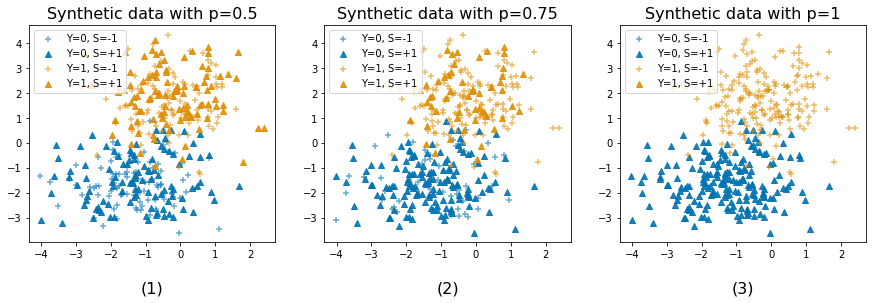

In [11]:
#todo syn_viz
def syn_viz(ps, alpha=0.9, k=2):
    """
    visualize the first two dimensions of the dataset along with their label and contamination
    """
    plt.figure(figsize=(5*len(ps), 4))
    sns.set_palette("colorblind", 10)
    palette = sns.color_palette("colorblind", 10)
    n_features = 2
    n_clusters = 1
    n_pool = 100*k#5000//K
    n = 100*k#5000//K
    for ip, p in enumerate(ps):
        np.random.seed(66)
        X, y, X_pool= make_unfair_poolclassif(n = n, n_features = n_features, n_classes = k, n_clusters = n_clusters, n_pool = n_pool, p = p)
        S = X[:,-1]
        plt.subplot(1, len(ps), ip+1)
        for cl in np.unique(y):
            plt.scatter(X[(y==cl) & (S!=1),0], X[(y==cl) & (S!=1),1], alpha = (alpha)/1.5, marker = "+", label=f"Y={int(cl)}, S=-1", color=palette[int(cl)])
            plt.scatter(X[(y==cl) & (S==1),0], X[(y==cl) & (S==1),1], alpha = alpha, marker = "^", label=f"Y={int(cl)}, S=+1", color=palette[int(cl)])
        plt.legend()
        plt.title(f"Synthetic data with p={p}", fontsize=16)
        plt.xlabel(f"\n({ip+1})", fontsize=16)
    #if S is not None:
    #    plt.scatter(X[S == 1,0], X[S == 1,1], alpha = alpha/3, color="red", marker="^")
    plt.show()
    return None
syn_viz([0.5, 0.75, 1])

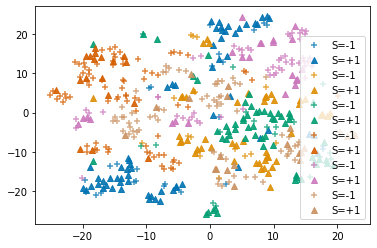

In [12]:
data_viz_tsne(X, y)

In [13]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("pool :", X_pool.shape)
print("train :", X_train.shape)
print("test :", X_test.shape)

pool : (4998, 21)
train : (3498, 21)
test : (1500, 21)


test : 0.7913333333333333
train : 0.7933104631217839
Normalized confusion matrix


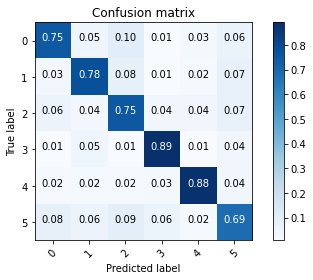

In [14]:
score_test, score_train, ovr = get_multiclass_performance(LogisticRegression(),
                                                          X_train,
                                                          X_test,
                                                          y_train,
                                                          y_test)


## 2. Fairness analysis on synthetic dataset

### 2.1. Without $\epsilon$-fairness

#### 2.1.1. Method 1 : Nelder-mead

A simplex algorithm. [Nelder-mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)

In [15]:
accs, kss, times, ind0, ind1, yd, yb, ydfh, ydfs, ybfh, ybfs = run_fairness_experimentation(
    RandomForestClassifier(),
    X,
    y,
    X_pool,
    n_times = 10,
    print_results = False,
    c = 0.001,
    soft_opt = "optim",
    do_ovr = False) # True

Accuracies
 unfair : 0.94 +-0.007
 fair_soft : 0.79 +-0.011

Unfairness
 unfair : 0.76 +-0.04
 fair_soft : 0.09 +-0.03

Times
 fair_soft : 3.506 +-0.591


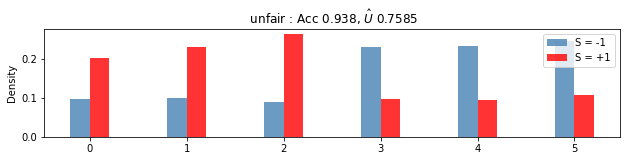

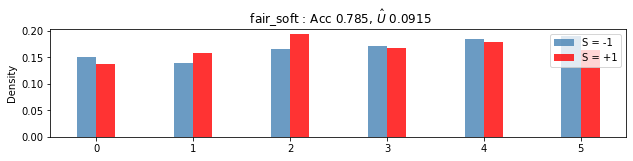

In [12]:
print_fairness_results(accs, kss, times)
viz_fairness_results(yd, ind0, ind1, accs, kss, "unfair")
viz_fairness_results(ydfs, ind0, ind1, accs, kss, "fair_soft")

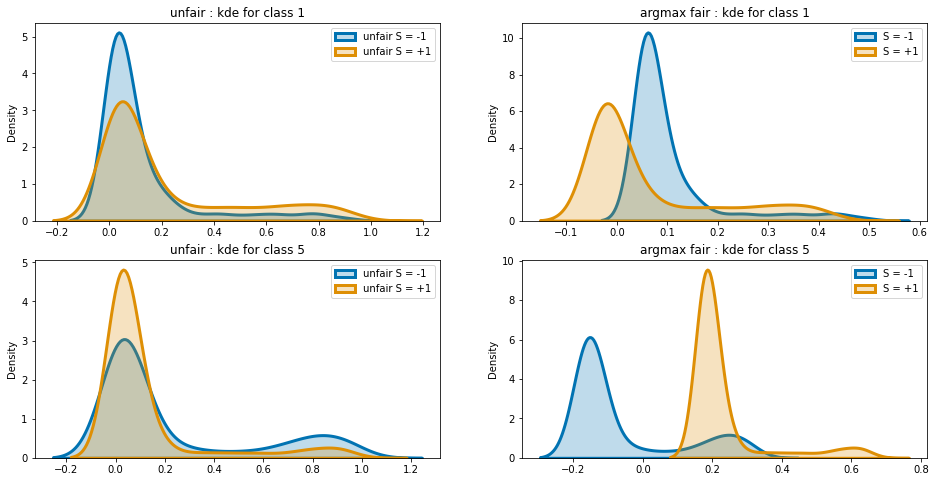

In [13]:
viz_fairness_distributions_(yb, ybfs, ind0, ind1, add_title="argmax")

#### 2.1.2. Method 2 : SAGD

In [14]:
accs, kss, times, ind0, ind1, yd, yb, ydfh, ydfs, ybfh, ybfs = run_fairness_experimentation(
    RandomForestClassifier(),
    X,
    y,
    X_pool,
    n_times = 10,
    print_results = False,
    c = 0.001,
    soft_opt = "SAGD",
    do_ovr = False) # True

lamb: [ 0.11421  0.09505  0.14681 -0.11478 -0.12812 -0.11316]
beta: [0. 0. 0. 0. 0. 0.]


Accuracies
 unfair : 0.94 +-0.006
 fair_soft : 0.79 +-0.008

Unfairness
 unfair : 0.75 +-0.05
 fair_soft : 0.08 +-0.03

Times
 fair_soft : 2.974 +-0.346


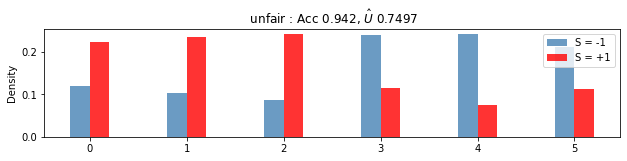

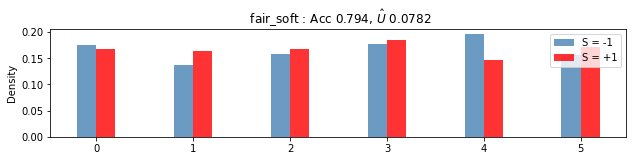

In [15]:
print_fairness_results(accs, kss, times)
viz_fairness_results(yd, ind0, ind1, accs, kss, "unfair")
viz_fairness_results(ydfs, ind0, ind1, accs, kss, "fair_soft")

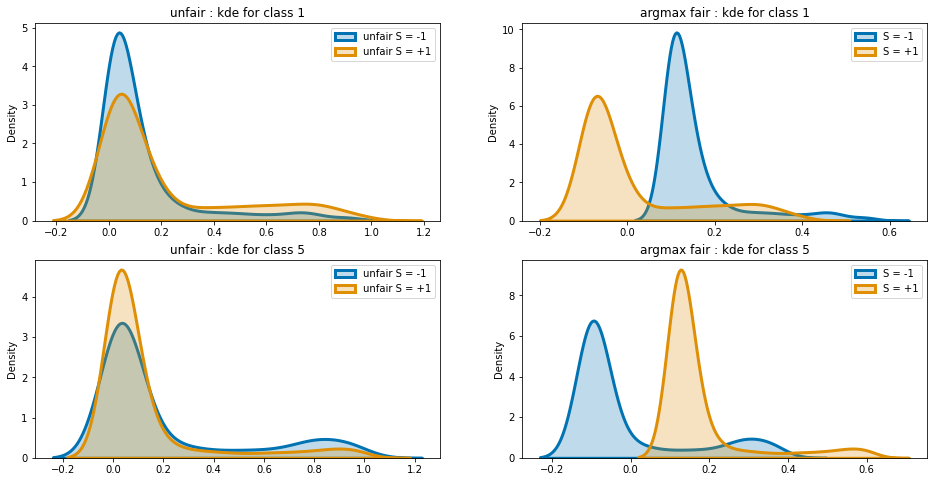

In [16]:
viz_fairness_distributions_(yb, ybfs, ind0, ind1, add_title="argmax")

### 2.2. With $\epsilon$-fairness

#### 2.2.1. Method 1 : trust-constr

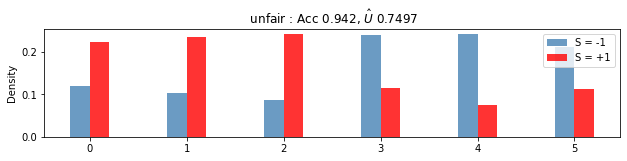

---------------------------
epsilon =  0.0
---------------------------
lamb: [13.72706 11.89985 11.92132 14.94779 10.95084 11.07639]
beta: [13.73834 11.93035 11.90475 15.18676 11.20491 11.31272]


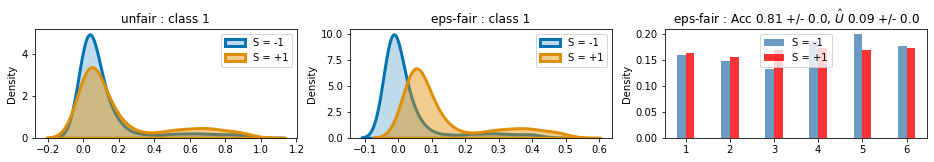

---------------------------
epsilon =  0.02
---------------------------
lamb: [0.10403 0.09322 0.13768 0.      0.      0.     ]
beta: [0.      0.      0.      0.11033 0.12152 0.09993]


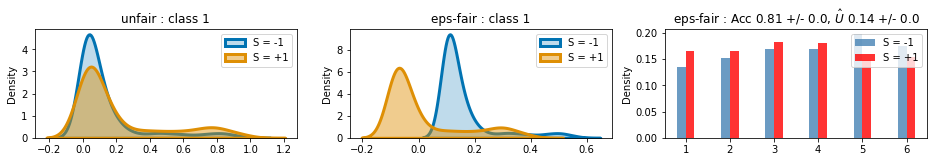

---------------------------
epsilon =  0.04
---------------------------
lamb: [0.07659 0.06594 0.11829 0.      0.      0.     ]
beta: [0.      0.      0.      0.11296 0.12078 0.10374]


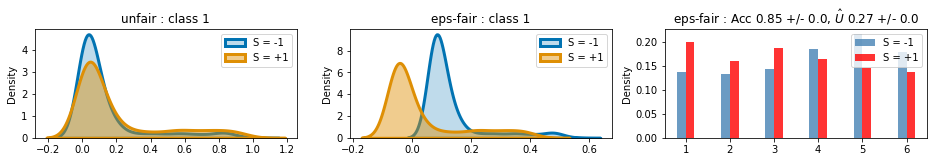

---------------------------
epsilon =  0.06
---------------------------
lamb: [0.06784 0.05937 0.11328 0.      0.      0.     ]
beta: [0.      0.      0.      0.093   0.10381 0.07165]


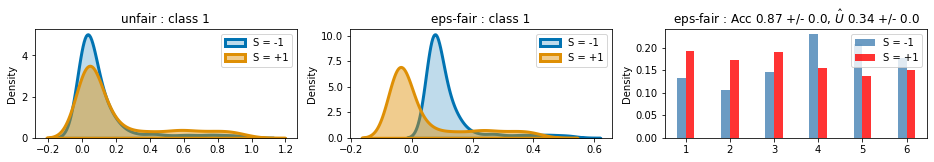

---------------------------
epsilon =  0.08
---------------------------
lamb: [0.05763 0.04538 0.0965  0.      0.      0.     ]
beta: [0.      0.      0.      0.0728  0.07473 0.04883]


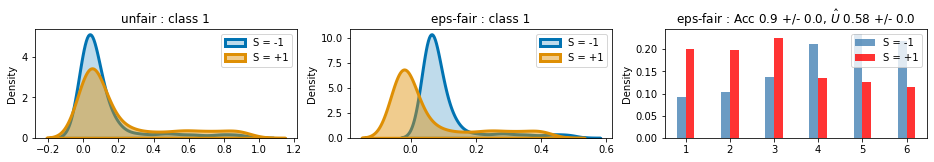

---------------------------
epsilon =  0.1
---------------------------
lamb: [0.03171 0.02086 0.06874 0.      0.      0.     ]
beta: [0.      0.      0.      0.05305 0.05318 0.01434]


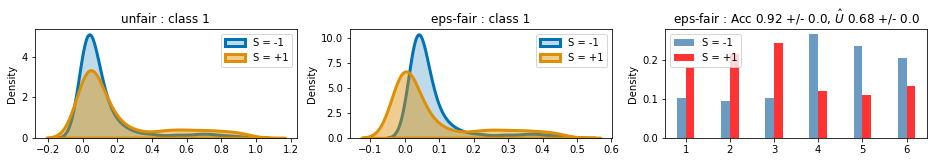

---------------------------
epsilon =  0.12
---------------------------
lamb: [3.200e-04 1.800e-04 1.562e-02 1.000e-05 1.000e-05 1.000e-05]
beta: [1.000e-05 1.000e-05 1.000e-05 2.073e-02 1.310e-03 1.200e-04]


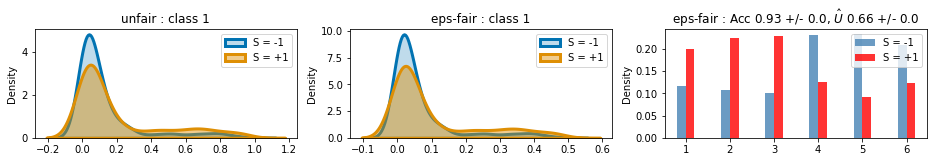

---------------------------
epsilon =  0.14
---------------------------
lamb: [3.3e-04 2.1e-04 8.7e-04 4.0e-05 4.0e-05 4.0e-05]
beta: [4.0e-05 4.0e-05 3.0e-05 2.0e-05 3.4e-04 3.5e-04]


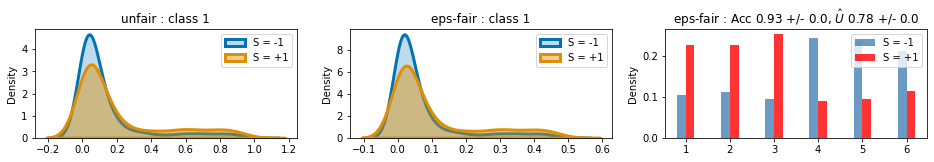

---------------------------
epsilon =  0.16
---------------------------
lamb: [0.0007  0.00087 0.00089 0.0001  0.00014 0.00013]
beta: [0.00012 0.00011 0.0001  0.00123 0.00066 0.00065]


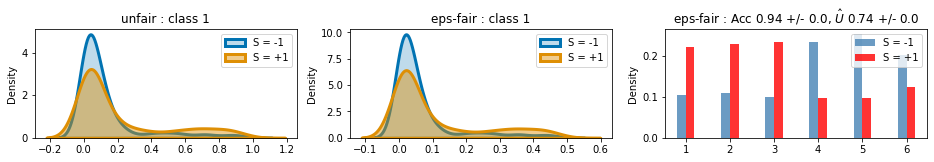

In [17]:
viz_fairness_results(yd, ind0, ind1, accs, kss, "unfair")
for epsilon_fair in np.arange(0, 0.18, 0.02):
    print("---------------------------")
    print("epsilon = ", round(epsilon_fair, 2))
    print("---------------------------")
    accs, kss, times, ind0, ind1, yd, yb, ydfh, ydfs, ybfh, ybfs = run_fairness_experimentation(
        RandomForestClassifier(),
        X,
        y,
        X_pool,
        n_times = 1,
        print_results = False,
        c = 0.005,
        soft_opt = "optim_bivar",
        do_ovr = False,
        epsilon_fair = epsilon_fair)
    viz_fairness_distributions_compact(yb, ybfs, ind0, ind1, accs, kss, add_title="eps-fair")
#0.18777  0.17289  0.21689 -0.04393 -0.0541  -0.04317

#### 2.2.2. Method 2 : SLSQP

Sequential Least Squares Programming ([SLSQP](https://en.wikipedia.org/wiki/Sequential_quadratic_programming))

---------------------------
epsilon =  0
---------------------------


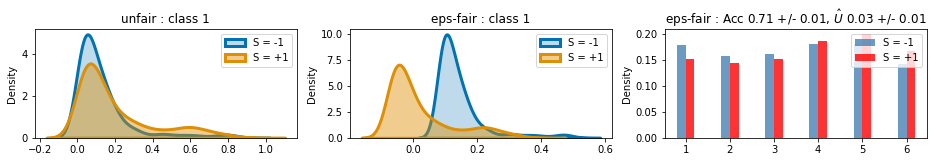

---------------------------
epsilon =  0.1
---------------------------


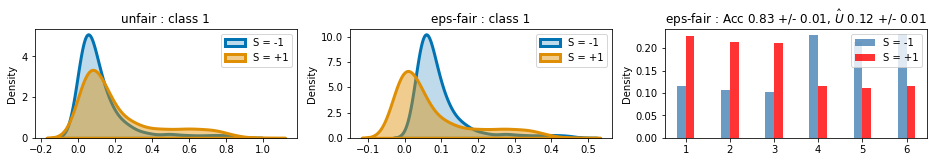

---------------------------
epsilon =  0.15
---------------------------


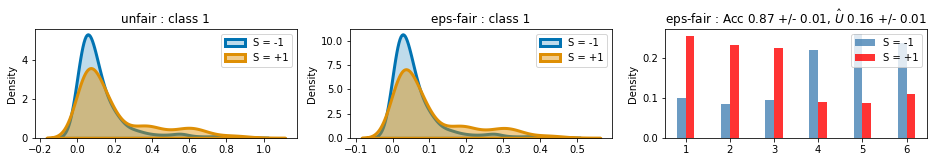

In [15]:
yb_by_epsilon = []
ybfs_by_epsilon = []
yd_by_epsilon = []
ydfs_by_epsilon = []
accs_by_epsilon = []
kss_by_epsilon = []
ind0_by_epsilon = []
ind1_by_epsilon = []
epsilon_interval = [0, 0.1, 0.15]

for epsilon_fair in epsilon_interval:
    print("---------------------------")
    print("epsilon = ", round(epsilon_fair, 2))
    print("---------------------------")
    accs, kss, times, ind0, ind1, yd, yb, ydfh, ydfs, ybfh, ybfs = run_fairness_experimentation(
        RandomForestClassifier(),
        X,
        y,
        X_pool,
        n_times = 30, #n_times=30
        print_results = False,
        c = 0.005,
        soft_opt = "optim_bivar_bis",
        do_ovr = False,
        epsilon_fair = epsilon_fair)
    yb_by_epsilon.append(yb)
    ybfs_by_epsilon.append(ybfs)
    yd_by_epsilon.append(yd)
    ydfs_by_epsilon.append(ydfs)
    accs_by_epsilon.append(accs)
    kss_by_epsilon.append(kss)
    ind0_by_epsilon.append(ind0)
    ind1_by_epsilon.append(ind1)
    viz_fairness_distributions_compact(yb, ybfs, ind0, ind1, accs, kss, add_title="eps-fair")

Let's keep this second method (SLSQP)

### 2.3. $\epsilon$ Analysis

- **Distribution of class 1**

In [16]:
epsilon_interval = [0, 0.1, 0.15]

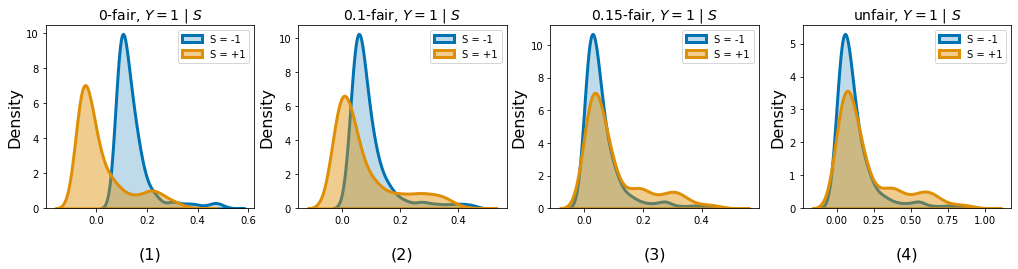

In [31]:
#fig = plt.figure(figsize=(16, len(interval)-1))
#spec = gridspec.GridSpec(ncols=5, nrows=len(interval)//5 + 1, wspace=0.42, hspace=0.5)
epsilon_interval2 = epsilon_interval#[:-1]
interval = np.arange(len(epsilon_interval))#[:-1]

fig = plt.figure(figsize=(14, 1.2*len(epsilon_interval2)))
ax = fig.add_axes([0,0,1,1])
cl = 1

sns.set_palette("colorblind", 10)
sns.color_palette("colorblind", 10)

for it, i in enumerate(interval):
    ind0 = ind0_by_epsilon[i]
    ind1 = ind1_by_epsilon[i]
    plt.subplot(1, 4, it+1)
    sns.kdeplot(ybfs_by_epsilon[i][ind0, cl], shade= True, linewidth= 3)
    sns.kdeplot(ybfs_by_epsilon[i][ind1, cl], shade= True, linewidth= 3, alpha = 0.45)
    plt.legend(labels=['S = -1',  'S = +1'])
    plt.title(f"{epsilon_interval[i]}-fair, $Y={cl} \ | \ S$", fontsize=14)
    plt.xlabel(f"\n({it+1})", fontsize=16)
    plt.ylabel(f"Density", fontsize=16)
    
plt.subplot(1, 4, len(interval)+1)
sns.kdeplot(yb[ind0, cl], shade= True, linewidth= 3)
sns.kdeplot(yb[ind1, cl], shade= True, linewidth= 3, alpha = 0.45)
plt.legend(labels=['S = -1',  'S = +1'])
plt.title(f"unfair, $Y={cl} \ | \ S$", fontsize=14)
plt.xlabel(f"\n({len(interval)+1})", fontsize=16)
plt.ylabel(f"Density", fontsize=16)

fig.tight_layout(pad=0.2)
plt.show()

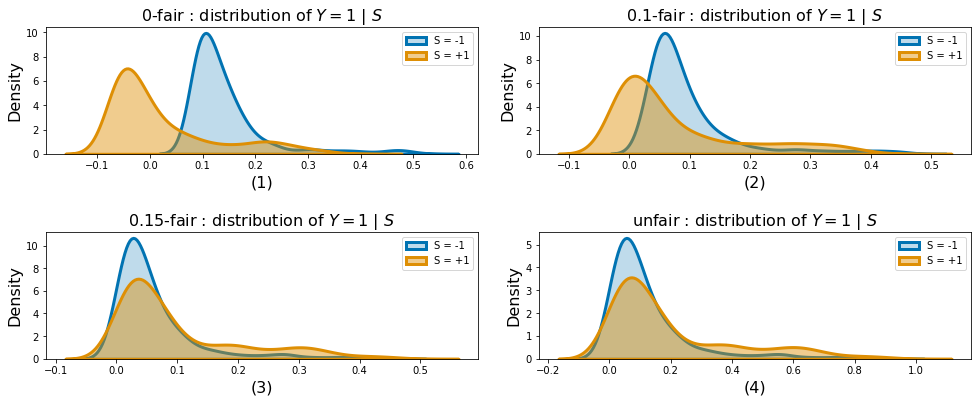

- **Phase diagram for $\epsilon$**

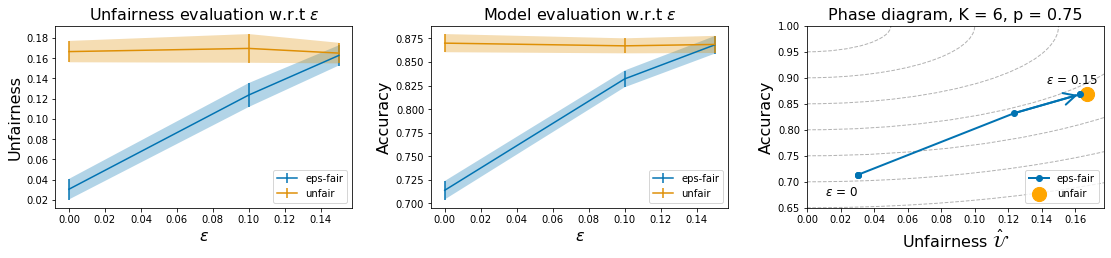

In [19]:
viz_eps_analysis(epsilon_interval, kss_by_epsilon, accs_by_epsilon, K=K, p=p)

### 2.3. K and p Analysis

In [20]:
epsilon_fair = 0
p = P #0.75
K = K
n_times = 30
analysis_args_param = {"param" : None,
                       "param_range" : None,
                       "n" : n,
                       "n_features" : N_FEATURES,
                       "n_classes" : K,
                       "n_clusters" : N_CLUSTERS,
                       "n_pool" : n_pool,
                       "p" : p,
                       "n_times" : n_times,
                       "model" : RandomForestClassifier(),
                       "c" : 0.005,
                       "print_ites" : True,
                       "draw_pool_in_train" : False,
                       "do_ovr" : False,
                       "compute_score_fair": False,
                       "epsilon_fair": epsilon_fair,
                       "epsilon_fair_range": None,
                       "print_lambda":True,
                       "viz_synthetic_data":False}

kss_syn_lst = []
accs_syn_lst = []
prange_syn_lst = []

- **Phase diagram for $p$**

In [21]:
p_range = [0.5, 0.6 , 0.7 , 0.8 , 0.9 , 0.99]
analysis_args_param["param"] = "p"
analysis_args_param["n_times"] = n_times
analysis_args_param["param_range"] = p_range
analysis_args_param["draw_pool_in_train"] = False
analysis_args_param["print_ites"] = True
analysis_args_param["print_lambda"] = False
analysis_args_param["viz_synthetic_data"] = False
analysis_args_param["epsilon_fair_range"] = [0.1, 0.05, 0]

kss_p, accs_p, times_p = analysis_params_fairness(**analysis_args_param)
kss_syn_lst.append(kss_p)
accs_syn_lst.append(accs_p)
prange_syn_lst.append(p_range)

0.5
0.6
0.7
0.8
0.9
0.99


- **Phase diagram for $K$**

In [26]:
## np.arange(5, 35, 5)
##np.arange(5, 40, 5)
#n_classes_range = [3, 6, 9, 12]
#analysis_args_param["param"] = "n_classes"
#analysis_args_param["n_times"] = n_times
#analysis_args_param["param_range"] = n_classes_range
#analysis_args_param["draw_pool_in_train"] = False
#analysis_args_param["print_ites"] = True
#analysis_args_param["print_lambda"] = False
#analysis_args_param["viz_synthetic_data"] = False
#analysis_args_param["epsilon_fair_range"] = [0.03, 0.02, 0]
#
#kss_classes, accs_classes, times_classes = analysis_params_fairness(**analysis_args_param)
#kss_syn_lst.append(kss_classes)
#accs_syn_lst.append(accs_classes)
#prange_syn_lst.append(n_classes_range)

3
6
9
12


- **Phase diagram for $\epsilon$**

In [22]:
epsilon_interval = [0.0, 0.05, 0.1, 0.15]
analysis_args_param["param"] = "epsilon_fair"
analysis_args_param["n_times"] = n_times
analysis_args_param["param_range"] = epsilon_interval
analysis_args_param["draw_pool_in_train"] = False
analysis_args_param["print_ites"] = True
analysis_args_param["print_lambda"] = False
analysis_args_param["viz_synthetic_data"] = False
analysis_args_param["epsilon_fair_range"] = None

kss_eps, accs_eps, times_eps = analysis_params_fairness(**analysis_args_param)
kss_syn_lst.append(kss_eps)
accs_syn_lst.append(accs_eps)
prange_syn_lst.append(epsilon_interval)

0.0
0.05
0.1
0.15


In [23]:
def viz_params_fairness(params, params_range, kss_params, accs_params, K, p, epsilon_fair, n_times, arrow=True):
    fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(len(params)*5, 5))

    sns.set_palette("colorblind")
    
    lst = [params, params_range, kss_params, accs_params]
    if not all(isinstance(x, list) for x in lst):
        raise ValueError('"params", "params_range", "kss_params" and "accs_params" should be a list of parameter names.')
    
    if len(params) == 1:
        param = params[0]
        param_range = params_range[0]
        kss_param = kss_params[0]
        accs_param = accs_params[0]
        for fair_name in list(accs_param.keys())[::-1]:
            x = np.array(kss_param[fair_name]["mean"])
            y = np.array(accs_param[fair_name]["mean"])
            line = axes.plot(x, y, label=fair_name, lw = 2)[0]
            if arrow:
                add_arrow(line)
            line.axes.annotate(f"{param_range[-1]}",
                xytext=(x[-1]-0.01, y[-1]-0.03),
                xy=(x[-1], y[-1]),
                size=12
            )
            color = line.get_color()
            axes.scatter(x[0], y[0], marker = "o", color=color)
            axes.scatter(x[-1], y[-1], marker = "o", color=color)
            for r in np.arange(0.05, 2, 0.05):
                axes.add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.2))
            line.axes.annotate(f"{param} = {param_range[0]}",
                    xytext=(x[0]-0.01, y[0]+0.02),
                    xy=(x[0], y[0]),
                    size=12
                )
        axes.legend(loc="best")
        axes.set_title(f"Phase diagram")
        axes.set_xlabel(r"Unfairness $\hat{\mathcal{U}}$")
        axes.set_ylabel("Accuracy")
        axes.set_xlim([min(kss_param["unfair"]["mean"])-0.05,max(kss_param["unfair"]["mean"])+0.05])
        axes.set_ylim([min(accs_param["unfair"]["mean"])-0.1,max(accs_param["unfair"]["mean"])+0.1])
    else:
        for i, param in enumerate(params):
            param_range = params_range[i]
            kss_param = kss_params[i]
            accs_param = accs_params[i]
            xlim_min = np.min([min(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
            xlim_max = np.max([max(kss_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
            ylim_min = np.min([min(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
            ylim_max = np.max([max(accs_param[fairname]["mean"]) for fairname in list(accs_param.keys())[::-1]])
            dx = (xlim_max - xlim_min)
            dy = (ylim_max - ylim_min)
            x0 = np.array(kss_param["unfair"]["mean"])[0]
            y0 = np.array(accs_param["unfair"]["mean"])[0]
            for fair_it, fair_name in enumerate(list(accs_param.keys())[::-1]):
                x = np.array(kss_param[fair_name]["mean"])
                y = np.array(accs_param[fair_name]["mean"])
                label_add = ""
                if fair_name == "eps-fair" and param != "$\epsilon$":
                    label_add = f", $\epsilon$={epsilon_fair}"
                
                if fair_name == "unfair" and param == "$\epsilon$":
                    axes[i].scatter(x.mean(), y.mean(), marker = "^", color="orange", label=fair_name, s=200)
                else:
                    line = axes[i].plot(x, y, label=fair_name+label_add, lw = 2)[0]
                    if arrow:
                        add_arrow(line)
                    color = line.get_color()
                    axes[i].text(x[-1]-0.08*dx, y[-1]-0.11*dy,
                                 f"{round(param_range[-1], 2)}",
                                 size=13,
                                 color=color)#,
                                 #bbox=dict(facecolor='none',
                                 #          edgecolor=color))
                    axes[i].scatter(x, y, marker = "o", color=color, s=20)
                    if param == "p":
                        if fair_it == len(accs_param) - 1:
                            #axes[i].scatter(x0, y0, marker = "o", color="crimson", s=350, alpha=1)
                            axes[i].text(x0-0.12*dx, y0+0.15*dy,
                                         f"{param} = {param_range[0]}",
                                         size=13,
                                         color="crimson",
                                         bbox=dict(facecolor='white',edgecolor="crimson"))
                    else:
                        axes[i].text(x[0]-0.19*dx, y[0]+0.03*dy,
                                     f"{param} = {param_range[0]}",
                                     size=13,
                                     color=color)#,
                                     #bbox=dict(facecolor='none',edgecolor=color))
            axes[i].legend(loc="best")
            if param == "K":
                title_add = f"p={p}"
            if param == "p":
                title_add = f"K={K}"
            if param == "$\epsilon$":
                title_add = f"K={K} and p={p}"
            axes[i].set_title(f"Phase diagram with " + title_add + f"\n({n_times} simulations)", fontsize=15)
            axes[i].set_xlabel(r"Unfairness $\hat{\mathcal{U}}$", fontsize=15)
            axes[i].set_ylabel("Accuracy", fontsize=15)
            axes[i].set_xlim([xlim_min-0.2*dx , xlim_max+0.2*dx])
            axes[i].set_ylim([ylim_min-0.2*dy,ylim_max+0.2*dy])
            for r in np.arange(0.05, 2, 0.05):
                axes[i].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='black', fill=False, alpha=.5))
    fig.tight_layout(pad=2.2)
    plt.show()


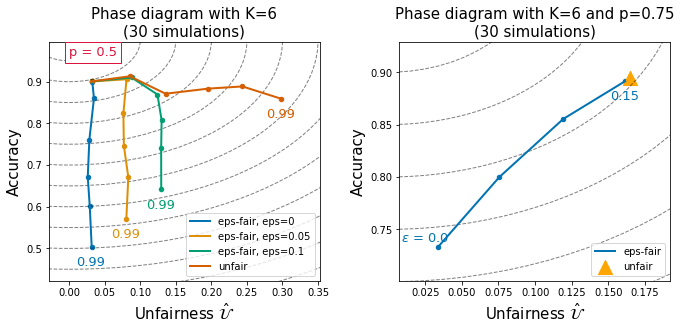

In [31]:
viz_params_fairness(params = ["p", "$\epsilon$"],
                    params_range = prange_syn_lst,
                    kss_params = kss_syn_lst,#[kss_syn_lst[0], kss_syn_lst[2]],
                    accs_params = accs_syn_lst,#[accs_syn_lst[0], accs_syn_lst[2]],
                    K = K,
                    p = p,
                    epsilon_fair = epsilon_fair,
                    n_times = n_times, arrow=False)